# Quality Assessment
Now it's your turn. Follow the steps on the platform and use what you've learnt to see how reliable the data is.

In [ ]:
import pandas as pd

Load our cleaned DataFrames

In [ ]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

Let's create a copy of our DataFrames, to make sure any of our changes won't affect the original DataFrame. We'll also change the DataFrames from `_cl` to `_qu`, so we can distinguish between the data that has been cleaned, and that which has been quality controlled.

In [ ]:
orders_qu = orders_cl.copy()
orderlines_qu = orderlines_cl.copy()
products_qu = products_cl.copy()

## 1.&nbsp; Define Pandas display format

In [ ]:
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_rows", 1000)

## 2.&nbsp; Exclude unwanted orders

### `orders` - Keep only orders with the state you want to work with
No `shopping cart`, `cancelled` etc...

In [ ]:
orders_qu.head()

,order_id,created_date,total_paid,state
0,241319,2017-01-02 13:35:40,44.99,Cancelled
1,241423,2017-11-06 13:10:02,136.15,Completed
2,242832,2017-12-31 17:40:03,15.76,Completed
3,243330,2017-02-16 10:59:38,84.98,Completed
4,243784,2017-11-24 13:35:19,157.86,Cancelled


Let's look at the make up of `state`.

In [ ]:
orders_qu.state.value_counts()

,count
state,
Shopping Basket,117809
Completed,46605
Place Order,40883
Pending,14374
Cancelled,7233


Seems like an overwhelming amount of the orders are left in the shopping basket - something we'll have to analyse another time. For this task we're interested in only `completed` orders, so let's filter our DataFrame.

In [ ]:
orders_qu.state

,state
0,Cancelled
1,Completed
2,Completed
3,Completed
4,Cancelled
...,...
226899,Place Order
226900,Shopping Basket
226901,Shopping Basket
226902,Shopping Basket


In [ ]:
# keep only completed orders
orders_qu = orders_qu.loc[orders_qu.state == "Completed", :]

In [ ]:
orders_qu.shape

(46605, 4)

### Keep only the orders that are present in both `orders` and `orderlines`

Let's begin by looking if there's a big difference between the amount of orders present in `orders` and `orderlines`.

In [ ]:
orders_qu.order_id.nunique()

46605

In [ ]:
orderlines_qu.id_order.nunique()

170213

What a huge difference! We want to make sure that every order_id in `orders` also exists in `orderlines` and vice versa.

Hence we'll perform an inner merge on the two tables using the `order_id` & `id_order`. This will then keep only the `order_id`'s that are present in both tables, which will then help us filter our `_qu` DataFrames once again.

In [ ]:
orders_orderlines = orders_qu.merge(orderlines_qu, how="inner", left_on="order_id", right_on="id_order")

In [ ]:
orders_orderlines

,order_id,created_date,total_paid,state,id,id_order,product_id,product_quantity,sku,unit_price,date
0,241423,2017-11-06 13:10:02,136.15,Completed,1398738,241423,0,1,LAC0212,129.16,2017-11-06 12:47:20
1,242832,2017-12-31 17:40:03,15.76,Completed,1529178,242832,0,1,PAR0074,10.77,2017-12-31 17:26:40
2,243330,2017-02-16 10:59:38,84.98,Completed,1181923,243330,0,1,OWC0074,77.99,2017-02-15 17:07:44
3,245275,2017-06-28 11:35:37,149.00,Completed,1276706,245275,0,1,TAD0007,149.00,2017-06-28 11:12:30
4,245595,2017-01-21 12:52:47,112.97,Completed,1154394,245595,0,2,PAC1561,52.99,2017-01-21 12:49:00
...,...,...,...,...,...,...,...,...,...,...,...
56709,527042,2018-03-14 11:47:50,18.98,Completed,1649446,527042,0,1,APP0927,13.99,2018-03-14 11:42:38
56710,527070,2018-03-14 11:50:48,24.97,Completed,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01
56711,527074,2018-03-14 11:51:42,24.97,Completed,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36
56712,527096,2018-03-14 11:58:40,34.96,Completed,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35


In [ ]:
# order_ids that are in both tables
order_ids = orders_orderlines["order_id"].unique()

In [ ]:
order_ids

array([241423, 242832, 243330, ..., 527074, 527096, 527112])

In [ ]:
# keep those ids in orders
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(order_ids), :]

# keep those ids in orderlines
orderlines_qu = orderlines_qu.loc[orderlines_qu["id_order"].isin(order_ids), :]

Let's have a quick check to make sure we're filtering both DataFrames the same. They should both contain the same number of unique `order_id`'s.

In [ ]:
orders_qu["order_id"].nunique(), orderlines_qu["id_order"].nunique()

(43064, 43064)

## 3.&nbsp; Exclude orders with unknown products

Let's start by investigating `orderlines` and `products`. We want to make sure that every product in `orderlines` has a matching entry in `products`. All orders with a missing product need to be removed from both `orderlines` and `orders`.

A left-join can help us here:

Joining `orderlines` left on `products` will keep all orderlines, and add the information of `products` on the matching skus. If an sku has been sold in `orderlines`, but the sku does not have an entry in `products` then the product_name will be empty.

In [ ]:
orderlines_products = orderlines_qu.merge(products_qu, how="left", on = "sku")[["id_order","sku","name" ]]
orderlines_products.sample(10)

,id_order,sku,name
5309,315181,OWC0035-2,Mac memory OWC 8GB (2x4GB) SO-DIMM DDR3 1066MHZ
23915,399490,APP1214,Apple Magic Mouse 2
46659,485345,CRU0052-2,Crucial memory Mac 16GB (2x8GB) SO-DIMM DDR4 2...
28019,415653,XDO0043,X-Doria Defense Edge Apple 42mm Watch Case Bla...
41397,466359,AP20264,Like new - Apple iPhone 7 Plus 128GB RED
9180,327449,LAC0182,LaCie Porsche Design Mobile Hard Drive 4TB USB...
2751,308397,LGE0034,"LG 29UM68-P Monitor 29 ""IPS widescreen UXGA Ultra"
53987,515149,CRU0015-2,NaN
39817,460361,APP1570,Apple Lightning to USB 3.0 Adapter
38924,455525,OWC0202,OWC miniStack USB 3.1 External Box


We can count how many missing products we have.

In [ ]:
orderlines_products.name.isna().value_counts()

,count
name,
False,55320
True,1394


Looks like the vast majority of products are known.

We can't simply delete the rows containing unknown products. We need to remove the entirety of any order that contains an unknown product to keep a consistent and coherent dataset.

In [ ]:
orders_to_delete = orderlines_products.loc[orderlines_products.name.isna(), "id_order"].unique()
orders_to_delete

array([299638, 299706, 299712, ..., 526106, 526122, 526363])

Keep only orders in `orders` and `orderlines`, that are not in this list of corrupted orders.

In [ ]:
orders_qu = orders_qu.loc[~orders_qu.order_id.isin(orders_to_delete),:]

In [ ]:
orderlines_qu = orderlines_qu.loc[~orderlines_qu.id_order.isin(orders_to_delete),:]

Let's have a quick check to make sure we're filtering both DataFrames the same. They should both contain the same number of unique `order_id`'s.

In [ ]:
orders_qu["order_id"].nunique(), orderlines_qu["id_order"].nunique()

(41701, 41701)

## 4.&nbsp; Explore the revenue from different tables

In a consistent and coherent dataset the value of an order should roughly match the sum of all items bought on that order. Let's investigate...

In [ ]:
orderlines_qu_copy = orderlines_qu.copy()

In [ ]:
orders_qu_copy = orders_qu.copy()

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [ ]:
orderlines_qu_copy["unit_price_total"] = orderlines_qu_copy["product_quantity"] * orderlines_qu_copy["unit_price"]

In [ ]:
orderlines_qu_copy.tail(10)

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total
215873,1649440,527035,0,1,APP0498,23.00,2018-03-14 11:41:55,23.00
215874,1649441,527034,0,1,APP0927,13.99,2018-03-14 11:42:01,13.99
215876,1649446,527042,0,1,APP0927,13.99,2018-03-14 11:42:38,13.99
215877,1649447,527035,0,1,APP0698,9.99,2018-03-14 11:42:41,9.99
215886,1649468,525664,0,1,TUC0336,7.93,2018-03-14 11:43:59,7.93
215889,1649474,525664,0,1,TUC0207,16.52,2018-03-14 11:45:05,16.52
215906,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01,19.98
215911,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36,19.98
215932,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35,29.97
215949,1649593,527112,0,1,APP0698,9.99,2018-03-14 11:58:13,9.99


#### Step 2:
Group by `id_order`, summarising by the sum of `unit_price_total`

In [ ]:
orderlines_cl.groupby("id_order")["unit_price"].sum()

,unit_price
id_order,
241319,44.99
241355,67.99
241423,129.16
242832,10.77
243330,77.99
...,...
527397,42.99
527398,42.99
527399,141.58


In [ ]:
orderlines_order_ids = orderlines_qu_copy.groupby("id_order", as_index=False)["unit_price_total"].sum()
# as_index=False changes the return so that the groupedby column remains a column (not the index)

In [ ]:
orderlines_order_ids

,id_order,unit_price_total
0,241423,129.16
1,242832,10.77
2,243330,77.99
3,245275,149.00
4,245595,105.98
...,...,...
41696,527042,13.99
41697,527070,19.98
41698,527074,19.98
41699,527096,29.97


### What is the average difference between `total_paid` and `unit_price_total`?

Let's merge our grouped `orderlines` table with the `orders` table, so we can calculate the differences in prices.

In [ ]:
diff_df = orders_qu_copy.merge(orderlines_order_ids, left_on="order_id", right_on="id_order")

In [ ]:
diff_df

,order_id,created_date,total_paid,state,id_order,unit_price_total
0,241423,2017-11-06 13:10:02,136.15,Completed,241423,129.16
1,242832,2017-12-31 17:40:03,15.76,Completed,242832,10.77
2,243330,2017-02-16 10:59:38,84.98,Completed,243330,77.99
3,245275,2017-06-28 11:35:37,149.00,Completed,245275,149.00
4,245595,2017-01-21 12:52:47,112.97,Completed,245595,105.98
...,...,...,...,...,...,...
41696,527042,2018-03-14 11:47:50,18.98,Completed,527042,13.99
41697,527070,2018-03-14 11:50:48,24.97,Completed,527070,19.98
41698,527074,2018-03-14 11:51:42,24.97,Completed,527074,19.98
41699,527096,2018-03-14 11:58:40,34.96,Completed,527096,29.97


In [ ]:
diff_df["difference"] = diff_df["total_paid"] - diff_df["unit_price_total"]
diff_df.head(10)

,order_id,created_date,total_paid,state,id_order,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,241423,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,242832,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,243330,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,245275,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,245595,105.98,6.99
5,246405,2017-11-24 10:01:27,407.96,Completed,246405,275.75,132.21
6,247524,2018-01-09 14:21:34,167.98,Completed,247524,162.99,4.99
7,247643,2017-05-26 11:50:35,153.54,Completed,247643,153.54,0.00
8,250275,2017-11-19 22:34:54,54.99,Completed,250275,51.00,3.99
9,251302,2017-05-10 12:27:33,140.99,Completed,251302,140.99,0.00


Now that we know the difference for each order, we can compute the average.

In [ ]:
diff_df.difference.mean().round(2)

4.47

### What is the distribution of these differences?

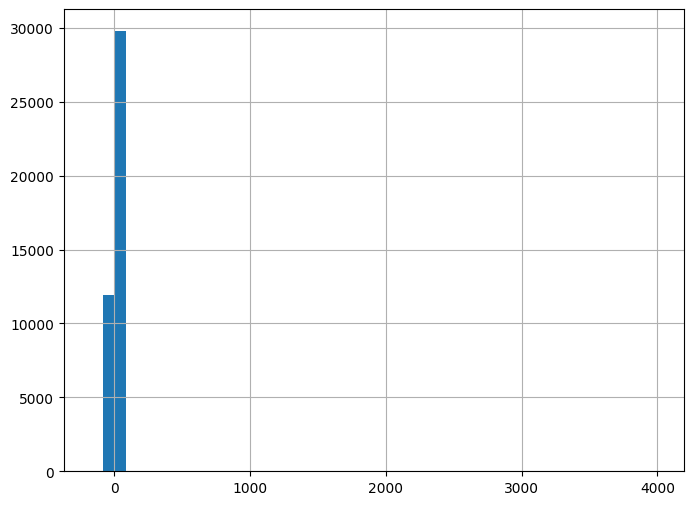

In [ ]:
diff_df.difference.hist(bins= 50, figsize=(8,6));

Looking at the spread of the data above, some of the difference must be due to corruption. Let's use `.describe()` to investigate the distribution further.

In [ ]:
diff_df.difference.describe()

,difference
count,41701.00
mean,4.47
std,26.05
min,-165.00
25%,0.00
50%,4.99
75%,6.99
max,3984.99


We can see from the our quartiles (0.00, 4.99, 6.99) that most of our data fits an expected pattern - free, 4.99, and 6.99 all seem like reasonable prices to assume as postage. However, look at the min and the max values, -165.00 and 3984.99, this can only occur due to corrupted data.

### Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

What reasons have you come up with to explain the difference?

### If there are differences that you can’t explain: what should you do with these orders?
There's a rule of thumb, that anything:
+ lower than the 25% quartile - (1.5 x interquartile range), or
+ higher than the 75% quartile + (1.5 x interquartile range)

is an outlier. Let's use this rule to try and exclude any corrupted data.

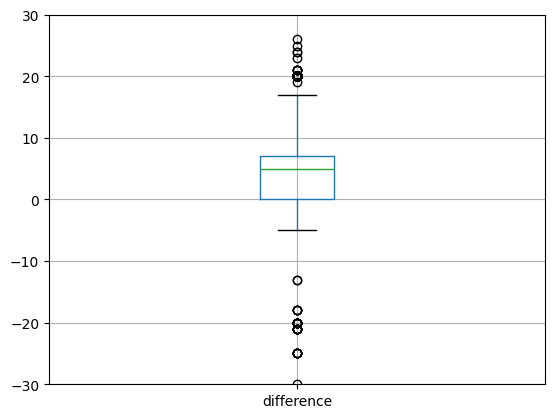

In [ ]:
# We know this rule from the boxplot
import matplotlib.pyplot as plt

ax = diff_df.boxplot("difference");
ax.set_ylim(-30, +30)
plt.show()

In [ ]:
# calculate the quartiles
Q1 = diff_df["difference"].quantile(0.25)
Q3 = diff_df["difference"].quantile(0.75)

Q1, Q3

(0.0, 6.989999999999981)

In [ ]:
# calculate the interquartile range
IQR = Q3-Q1
IQR

6.989999999999981

In [ ]:
# lower boundary
Q1 - 1.5*IQR

-10.484999999999971

In [ ]:
# upper boundary
Q3 + 1.5*IQR

17.47499999999995

In [ ]:
# filter the DataFrame to include only "non-outliers"
diff_no_outliers_df = diff_df.loc[
    (diff_df["difference"] >= (Q1 - 1.5*IQR))
    &
    (diff_df["difference"] <= (Q3 + 1.5*IQR))
    ,
    :]

Let's look at the distribution again to see the effect of removing the outliers.

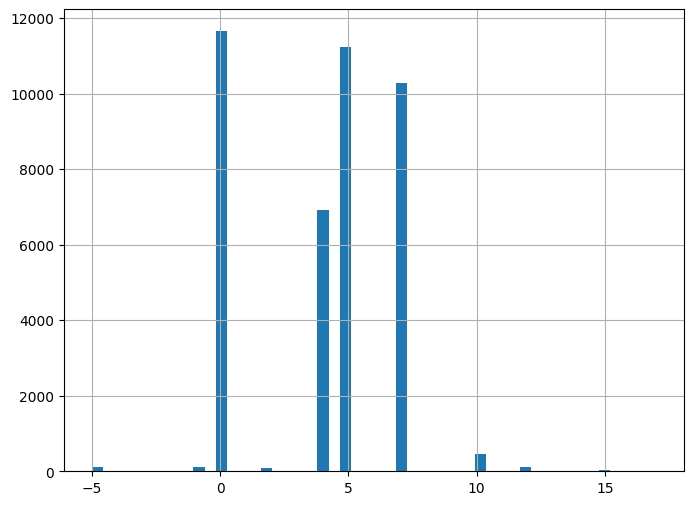

In [ ]:
diff_no_outliers_df.difference.hist(bins= 50, figsize=(8,6));

<Axes: >

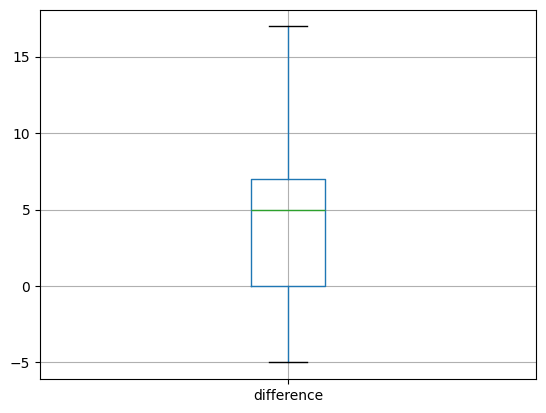

In [ ]:
diff_no_outliers_df.boxplot("difference")

This looks much more like what we would expect: a small difference, but nothing extreme.

Now we need to remove these orders with extreme differences from our `orders_lines_merged` DataFrame.

In [ ]:
normal_diff_list = diff_no_outliers_df["order_id"]

In [ ]:
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(normal_diff_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_qu["id_order"].isin(normal_diff_list), :]

In [ ]:
orders_qu["order_id"].nunique(), orderlines_qu["id_order"].nunique()

(40985, 40985)

## 5.&nbsp; Become confident about your dataset

Let's hear your thoughts about what you discovered.

Let's not forget to download our quality controlled DataFrames

In [ ]:
# from google.colab import files

# orders_qu.to_csv("orders_qu.csv", index=False)
# files.download("orders_qu.csv")

# orderlines_qu.to_csv("orderlines_qu.csv", index=False)
# files.download("orderlines_qu.csv")

In [ ]:
orders_qu

,order_id,created_date,total_paid,state
1,241423,2017-11-06 13:10:02,136.15,Completed
2,242832,2017-12-31 17:40:03,15.76,Completed
3,243330,2017-02-16 10:59:38,84.98,Completed
5,245275,2017-06-28 11:35:37,149.00,Completed
6,245595,2017-01-21 12:52:47,112.97,Completed
...,...,...,...,...
226544,527042,2018-03-14 11:47:50,18.98,Completed
226572,527070,2018-03-14 11:50:48,24.97,Completed
226576,527074,2018-03-14 11:51:42,24.97,Completed
226598,527096,2018-03-14 11:58:40,34.96,Completed


In [ ]:
orders_qu

,order_id,created_date,total_paid,state
1,241423,2017-11-06 13:10:02,136.15,Completed
2,242832,2017-12-31 17:40:03,15.76,Completed
3,243330,2017-02-16 10:59:38,84.98,Completed
5,245275,2017-06-28 11:35:37,149.00,Completed
6,245595,2017-01-21 12:52:47,112.97,Completed
...,...,...,...,...
226544,527042,2018-03-14 11:47:50,18.98,Completed
226572,527070,2018-03-14 11:50:48,24.97,Completed
226576,527074,2018-03-14 11:51:42,24.97,Completed
226598,527096,2018-03-14 11:58:40,34.96,Completed


In [ ]:
orders_qu['created_date'] = pd.to_datetime(orders_qu['created_date'])

In [ ]:
# What is the time period that the dataset covers?
orders_qu['created_date'].min() , orders_qu['created_date'].max()

(Timestamp('2017-01-01 01:51:47'), Timestamp('2018-03-14 12:03:52'))

In [ ]:
# What is the overall revenue for that time?
orders_qu['total_paid'].sum()

7978675.599999999

In [ ]:
# Are there seasonal patterns in the evolution of sales?
orders_qu['month'] = orders_qu['created_date'].dt.month
[month%12 // 3 + 1 for month in range(1, 13)] # Winter (1), Spring (2), Summer (3), Fall (4)
orders_qu['season'] = orders_qu['created_date'].dt.month% 12 // 3 + 1

orders_qu.groupby('season')['total_paid'].sum()

,total_paid
season,
1,3389800.90
2,818136.78
3,1288674.96
4,2482062.96


In [ ]:
orderlines_qu


,id,id_order,product_id,product_quantity,sku,unit_price,date
6,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16
7,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34
8,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11
15,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14
21,1119145,299561,0,1,PEB0015,142.49,2017-01-01 02:38:50
...,...,...,...,...,...,...,...
215877,1649447,527035,0,1,APP0698,9.99,2018-03-14 11:42:41
215906,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01
215911,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36
215932,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35


In [ ]:
# What are the most sold products?
orderlines_qu.groupby('id')['product_quantity'].sum().sort_values(ascending= False)


,product_quantity
id,
1436657,72
1573834,50
1604948,37
1121091,35
1422565,35
...,...
1307785,1
1307787,1
1307788,1


In [ ]:
orderlines_qu['total_quantity'] = orderlines_qu.groupby('id')['product_quantity'].transform('sum')
orderlines_qu_sorted = orderlines_qu.sort_values(by='total_quantity', ascending=False)


In [ ]:
orderlines_qu_sorted

,id,id_order,product_id,product_quantity,sku,unit_price,date,total_quantity
138300,1436657,438871,0,72,SAN0186,8.65,2017-11-24 12:44:49,72
188292,1573834,495987,0,50,STA0016,9.99,2018-01-22 12:16:31,50
198405,1604948,507768,0,37,SAN0110,9.00,2018-02-07 19:08:22,37
921,1121091,300475,0,35,OTT0132,29.99,2017-01-02 12:14:04,35
132042,1422565,432242,0,35,CRU0050,77.90,2017-11-22 20:28:58,35
...,...,...,...,...,...,...,...,...
86144,1307785,384545,0,1,JBL0104,26.99,2017-07-31 14:58:24,1
86146,1307787,384545,0,1,PIE0009,14.99,2017-07-31 14:59:16,1
86147,1307788,384548,0,1,PAC0622,214.59,2017-07-31 14:59:18,1
86148,1307792,384549,0,1,LEX0032,25.99,2017-07-31 15:02:47,1


In [ ]:
# What are the products that generate the most revenue?
orderlines_qu['total_revenue'] = orderlines_qu['unit_price'] * orderlines_qu['total_quantity']
orderlines_qu.sort_values(by= 'total_revenue', ascending=False)

,id,id_order,product_id,product_quantity,sku,unit_price,date,total_quantity,total_revenue
134328,1427896,434662,0,32,SAM0070,214.90,2017-11-23 13:52:48,32,6876.80
191126,1582288,499191,0,12,LGE0044,569.99,2018-01-26 14:51:39,12,6839.88
89854,1315561,388292,0,20,DLL0035,289.99,2017-08-10 14:18:07,20,5799.80
104369,1358679,403104,0,8,LGE0044,559.99,2017-09-22 10:52:59,8,4479.92
57740,1248063,355941,0,7,APP1985,632.00,2017-05-15 13:10:00,7,4424.00
...,...,...,...,...,...,...,...,...,...
186029,1566612,493168,0,1,OWC0013,2.49,2018-01-17 20:04:01,1,2.49
182734,1557881,489744,0,1,OWC0013,2.49,2018-01-12 17:31:22,1,2.49
185764,1565937,492896,0,1,OWC0013,2.49,2018-01-17 12:34:12,1,2.49
192513,1587006,500910,0,1,OWC0013,2.49,2018-01-29 12:55:05,1,2.49


In [ ]:
products_qu

,sku,name,desc,price,in_stock,type
0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696
1,APP0023,Apple Mac Keyboard Keypad Spanish,USB ultrathin keyboard Apple Mac Spanish.,59.00,0,13855401
2,APP0025,Mighty Mouse Apple Mouse for Mac,mouse Apple USB cable.,59.00,0,1387
3,APP0072,Apple Dock to USB Cable iPhone and iPod white,IPhone dock and USB Cable Apple iPod.,25.00,0,1230
4,KIN0007,Mac Memory Kingston 2GB 667MHz DDR2 SO-DIMM,2GB RAM Mac mini and iMac (2006/07) MacBook Pr...,34.99,1,1364
...,...,...,...,...,...,...
9987,BEL0376,Belkin Travel Support Apple Watch Black,compact and portable stand vertically or horiz...,29.99,1,12282
9988,THU0060,"Enroute Thule 14L Backpack MacBook 13 ""Black",Backpack with capacity of 14 liter compartment...,69.95,1,1392
9989,THU0061,"Enroute Thule 14L Backpack MacBook 13 ""Blue",Backpack with capacity of 14 liter compartment...,69.95,1,1392
9990,THU0062,"Enroute Thule 14L Backpack MacBook 13 ""Red",Backpack with capacity of 14 liter compartment...,69.95,0,1392


In [ ]:
orderlines_qu.shape[0] , products_qu.shape[0]

(53231, 9992)

In [ ]:
products_qu.head()

,sku,name,desc,price,in_stock,type
0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696
1,APP0023,Apple Mac Keyboard Keypad Spanish,USB ultrathin keyboard Apple Mac Spanish.,59.00,0,13855401
2,APP0025,Mighty Mouse Apple Mouse for Mac,mouse Apple USB cable.,59.00,0,1387
3,APP0072,Apple Dock to USB Cable iPhone and iPod white,IPhone dock and USB Cable Apple iPod.,25.00,0,1230
4,KIN0007,Mac Memory Kingston 2GB 667MHz DDR2 SO-DIMM,2GB RAM Mac mini and iMac (2006/07) MacBook Pr...,34.99,1,1364


In [ ]:
# Analyze data
ol_pr_qu = orderlines_qu.merge(products_qu, on= 'sku', how= 'left')

ol_pr_qu.head()

,id,id_order,product_id,product_quantity,sku,unit_price,date,total_quantity,total_revenue,name,desc,price,in_stock,type
0,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,1,47.49,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,60.99,1,12755395
1,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,1,18.99,iOttie Easy View 2 Car Black Support,IPhone car holder 7 plus / 7/6 Plus / 6 / 5s /...,22.95,0,5720
2,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11,1,72.19,Apple 85W MagSafe 2 charger MacBook Pro screen...,Apple MagSafe 2 Charger for MacBook Pro 15-inc...,89.00,1,13005399
3,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14,1,60.90,(Open) Crucial 240GB SSD 7mm BX200,SSD hard drive and high-speed performance with...,76.99,0,1298
4,1119145,299561,0,1,PEB0015,142.49,2017-01-01 02:38:50,1,142.49,Pebble Smartwatch Time Steel Black,Bluetooth Smart Watch with steel case leather ...,299.99,0,11905404


In [ ]:
# How many products are being discounted?
ol_pr_qu['discount'] = ol_pr_qu['price'] - ol_pr_qu['unit_price']

ol_pr_qu.loc[ol_pr_qu['discount'] < 0, :].count()


,0
id,1571
id_order,1571
product_id,1571
product_quantity,1571
sku,1571
unit_price,1571
date,1571
total_quantity,1571
total_revenue,1571
name,1571
